In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

df = pd.read_csv("HAM10000_clean.csv")

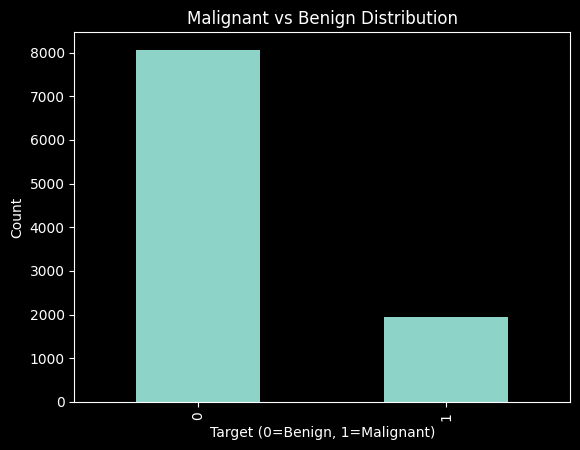

In [3]:
df["target"].value_counts().plot(
    kind="bar",
    title="Malignant vs Benign Distribution"
)

plt.xlabel("Target (0=Benign, 1=Malignant)")
plt.ylabel("Count")
plt.show()


악성이 상대적으로 매우 적음
accuracy만 쓰면 위험
악성 피부 병변의 비율이 낮은 불균형데이터로 정확도보다는 민감도 중심의 평가 필요

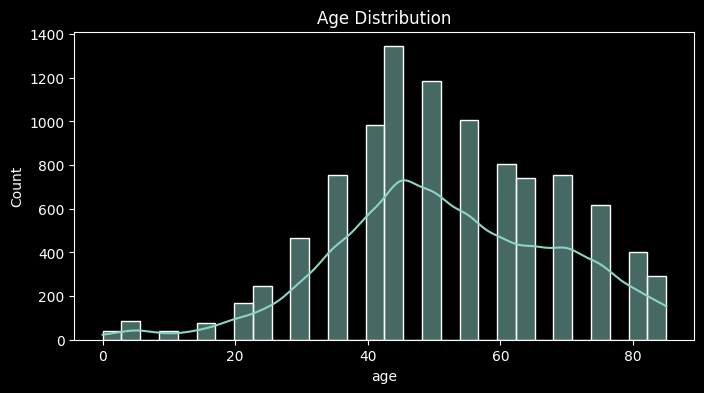

In [4]:
plt.figure(figsize=(8,4))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

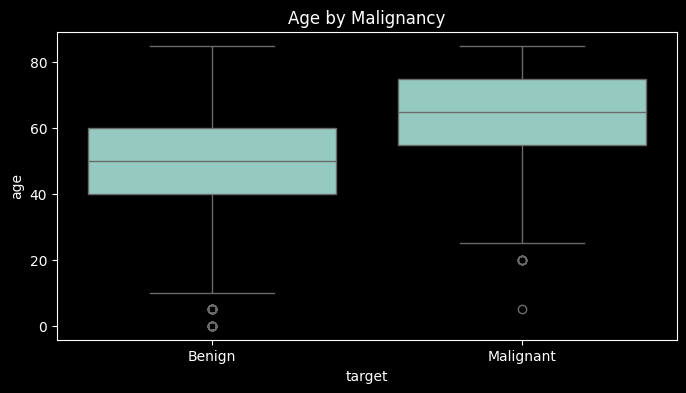

In [5]:
plt.figure(figsize=(8,4))
sns.boxplot(x="target", y="age", data=df)
plt.xticks([0,1], ["Benign", "Malignant"])
plt.title("Age by Malignancy")
plt.show()

악성 쪽이 중앙값이 더 높음
 age는 강력한 설명 변수

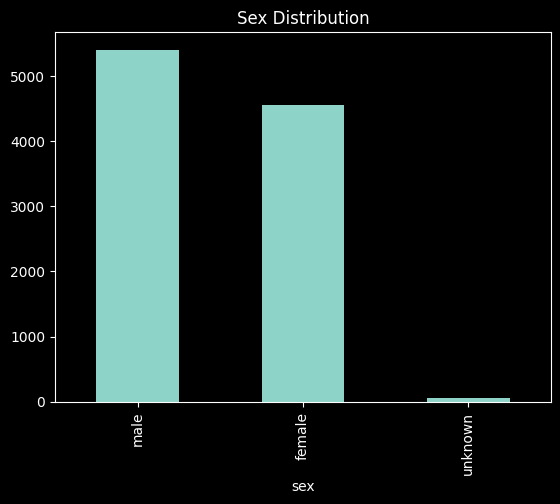

In [6]:
df["sex"].value_counts().plot(
    kind="bar",
    title="Sex Distribution"
)
plt.show()

남자도 여자도 아닌 성이 있음

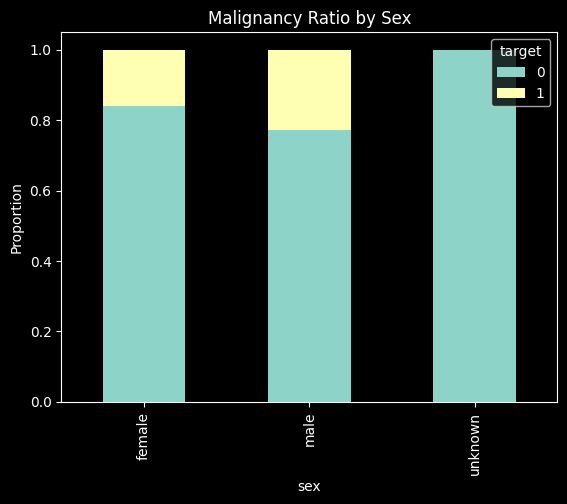

In [7]:
pd.crosstab(df["sex"], df["target"], normalize="index").plot(
    kind="bar", stacked=True
)
plt.title("Malignancy Ratio by Sex")
plt.ylabel("Proportion")
plt.show()


성별 간의 큰 차이가 없음

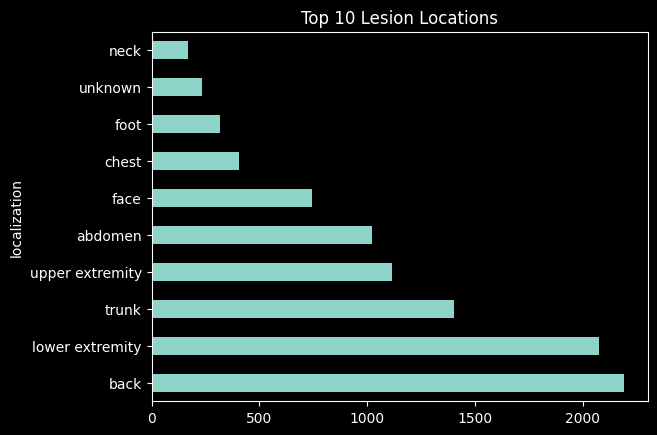

target,0,1
localization,,
face,0.573154,0.426846
scalp,0.632812,0.367188
ear,0.642857,0.357143
neck,0.684524,0.315476
chest,0.687961,0.312039
upper extremity,0.710197,0.289803
back,0.754106,0.245894
hand,0.822222,0.177778
lower extremity,0.848339,0.151661


In [8]:
df["localization"].value_counts().head(10).plot(
    kind="barh",
    title="Top 10 Lesion Locations"
)
plt.show()

pd.crosstab(
    df["localization"], df["target"],
    normalize="index"
).sort_values(by=1, ascending=False).head(10)

로지스틱 회귀
- 각 변수의 계수(coef)가 의미가 있음

랜덤 포레스트
- 예측은 잘함
- 왜 그렇게 판단했는지 설명이 어려움

In [9]:
feature = ["age", "sex", "localization", "dx_type"]
target = "target"

x = df[feature]
y = df[target]

num_cols = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = x.select_dtypes(include=["object"]).columns.tolist()

print("수치형:", num_cols)
print("범주형:", cat_cols)


수치형: ['age']
범주형: ['sex', 'localization', 'dx_type']


In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter = 1000,
    class_weight="balanced"
)


악성이 소수클래스이기 때문에 집중해서 학습

In [12]:
pipe = Pipeline(
    steps = [
        ("preprocess", preprocess),
        ("model", model)
    ]
)

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

pipe.fit(x_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = pipe.predict(x_test)
y_proba = pipe.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1612
           1       0.46      0.94      0.62       391

    accuracy                           0.78      2003
   macro avg       0.72      0.84      0.73      2003
weighted avg       0.88      0.78      0.80      2003

ROC-AUC 0.8799016963566093


precision(정밀도) : 모델이 1이다라고 예측한 것들 중에 진짜 1인 비율 0.46(46%)
>> 거짓 양성이 많다.
recall(재현율) : 실제로 1인 것들 중에서 모델이 1로 맞춘 비율
>> 클래스 1 : 0.94, 실제 1 중 94%를 잡아냄(false negative가 적다.)
F1-score(조화평균) : recall은 매우 좋지만 precision이 낮아서 f1이 중간정도로 내려감

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

num_cols = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = x.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=1000))
    ]
)

# 1) 모델이 '1일 확률'을 뱉게 하기
model.fit(x_train, y_train)
y_proba = model.predict_proba(x_test)[:, 1]
# 2) 여러 threshold를 시험해보기
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

rows = []
for t in thresholds:
    # 3) 확률 -> 0/1로 변환 (임계값 적용)
    y_pred = (y_proba >= t).astype(int)

    # 4) 성능 계산
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    })

df_result = pd.DataFrame(rows)
print(df_result)


   threshold  precision    recall        f1
0        0.2   0.470130  0.925831  0.623600
1        0.3   0.485484  0.769821  0.595450
2        0.4   0.521368  0.624041  0.568102
3        0.5   0.531690  0.386189  0.447407
4        0.6   0.552632  0.161125  0.249505
5        0.7   0.666667  0.051151  0.095012
6        0.8   0.000000  0.000000  0.000000
7        0.9   0.000000  0.000000  0.000000


/home/sujkim/miniconda3/envs/wsl_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sujkim/miniconda3/envs/wsl_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


재현율이 높은 f1점수를 선택한다.
대부분 암인데 암이 아니라고 놓치지 않는 것을 목표로 검사들이 진행되기 때문이다.

threshold = 0.2 
악성일 확률이 20%만 넘어도 악성으로 판단한다.

In [16]:
feature_names = (
    num_cols +
    list(pipe.named_steps["preprocess"]
         .named_transformers_["cat"]
         .get_feature_names_out(cat_cols))
)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": pipe.named_steps["model"].coef_[0]
}).sort_values(by="coef", ascending=False)

coef_df.head(10)

,feature,coef
22,dx_type_histo,4.768145
9,localization_face,0.715957
18,localization_upper extremity,0.562408
2,sex_male,0.525518
14,localization_neck,0.485195
1,sex_female,0.402994
8,localization_ear,0.310531
6,localization_back,0.283139
7,localization_chest,0.179211
15,localization_scalp,0.152495


coef > 0 : 해당 변수가 커질수록 악성일 가능성 높음
coef < 0 : 해당 변수가 0보다 작은 쪽으로 가면 악성일 가능성 낮음(방향성)
얼굴에 위치한 병변은 기준 위치 대비 악성 odds가 증가하는 경향(coef = 0.72)을 보였다.
odds : 어떤 일이 일어날 확률 대비, 일어나지 않을 확률의 비율
<의료데이터에서 odds를 쓰는 이유>
1. 위험 요인 해석에 적합
2. 케이스-컨트롤 연구와 잘 맞음
3. 논문, 임상 통계의 표준 언어

- 로지스틱 회귀를 쓰는 이유 -
원인 요인을 알 수 있기 때문에

/home/sujkim/miniconda3/envs/wsl_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Axes: title={'center': 'Recall / Precision by Threshold'}, xlabel='threshold'>

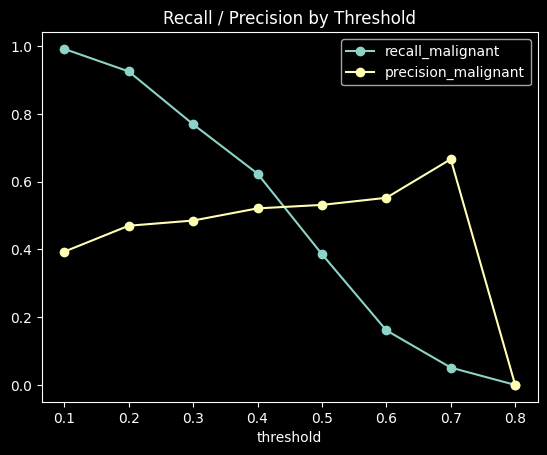

In [17]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.1)
rows = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    
    rows.append({
        "threshold" : round(t, 2),
        "recall_malignant" : recall_score(y_test, y_pred_t),
        "precision_malignant" : precision_score(y_test, y_pred_t),
        "f1_score" : f1_score(y_test, y_pred_t)
    })
    
thresholds_df = pd.DataFrame(rows)
thresholds_df

thresholds_df.plot(
    x="threshold",
    y=["recall_malignant", "precision_malignant"],
    marker="o",
    title="Recall / Precision by Threshold"
)

“Threshold를 0.1–0.8 범위에서 비교한 결과,
0.2에서 악성 병변 recall을 90% 이상 확보하면서도
precision의 급격한 감소는 발생하지 않아
의료적 의사결정 기준으로 적절하다고 판단하였다.”

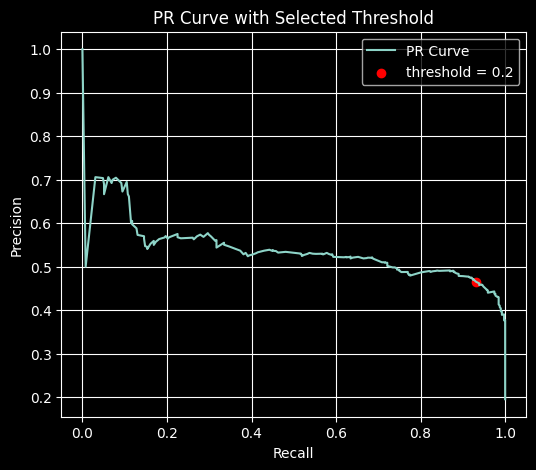

In [18]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt 
import numpy as np 

precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba
)

target_threshold = 0.2
idx = np.argmin(np.abs(thresholds - target_threshold))

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="PR Curve")
plt.scatter(
    recall[idx],
    precision[idx],
    color="red",
    label=f"threshold = {target_threshold}"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve with Selected Threshold")
plt.legend()
plt.grid(True)
plt.show()

t=0.25 | FP= 356 FN=  48 | recall=0.877 precision=0.491
t=0.28 | FP= 329 FN=  88 | recall=0.775 precision=0.479
t=0.30 | FP= 319 FN=  90 | recall=0.770 precision=0.485
t=0.32 | FP= 299 FN= 100 | recall=0.744 precision=0.493
t=0.35 | FP= 269 FN= 111 | recall=0.716 precision=0.510
t=0.38 | FP= 230 FN= 141 | recall=0.639 precision=0.521
t=0.40 | FP= 224 FN= 147 | recall=0.624 precision=0.521


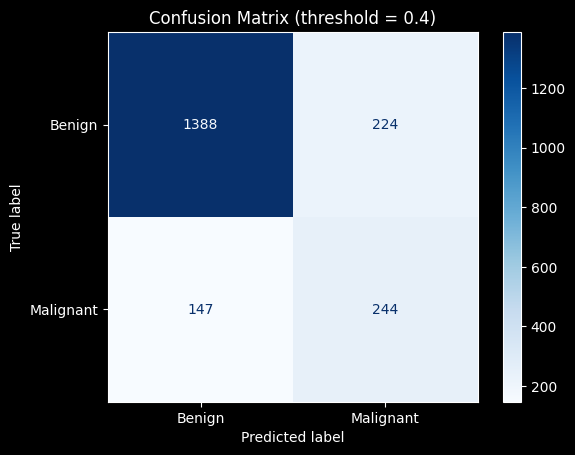

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
from sklearn.metrics import precision_recall_curve

# y_pred_02 = (y_proba >= 0.4).astype(int)
# cm = confusion_matrix(y_test, y_pred_02)
prec, rec, thr = precision_recall_curve(y_test, y_proba)

# 예: recall 0.85 이상인 구간에서 precision이 가장 높은 threshold 선택
# target_recall = 0.85
# idx = (rec >= target_recall).nonzero()[0]
# best_i = idx[prec[idx].argmax()]
# best_thr = thr[best_i-1]  # thr 길이가 하나 짧아서 보정
# best_thr

for t in [0.25, 0.28, 0.30, 0.32, 0.35, 0.38, 0.40]:
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) if (tp+fp) else 0
    print(f"t={t:.2f} | FP={fp:4d} FN={fn:4d} | recall={recall:.3f} precision={precision:.3f}")
    
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Benign", "Malignant"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix (threshold = 0.4)")
plt.show()

In [20]:
# 0 = Benign, 1 = Malignant
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

df = pd.read_csv("HAM10000_clean.csv")

y_prob = df["target"].to_numpy() * 0.7 + np.random.uniform(0, 0.3, size=len(df))

threshold = 0.2
y_pred = (y_prob >= threshold).astype(int)



cm = confusion_matrix(y_prob, y_pred)
cm

cm_df = pd.DataFrame({
    "true_label": ["Benign", "Benign", "Malignant", "Malignant"],
    "pred_label": ["Benign", "Malignant", "Benign", "Malignant"],
    "count": [cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
})

cm_df.to_csv("confusion_matrix_easy.csv", index=False)


ValueError: Classification metrics can't handle a mix of continuous and binary targets

본 모델은 악성 병변 미검출의 위험을 최소화하기 위해
민감도 중심의 분류 기준을 적용하였다.
그 결과, 악성 병변에 대한 탐지율은 높게 유지되었으며,
추가 검사로 보완 가능한 False Positive는
의료적 의사결정 범위 내에서 허용 가능한 수준으로 판단된다.